In [1]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import time
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
import wandb
from omegaconf import OmegaConf

from pathlib import Path

In [14]:
root_path = Path().cwd().parent
config_path = root_path / "logs/hydra/2025-11-01_17-56-50/.hydra/config.yaml"
print(f"Root path: {root_path}")
print(f"Config path: {config_path}")

Root path: /home/s204790/dynamical-pde-diffusion
Config path: /home/s204790/dynamical-pde-diffusion/logs/hydra/2025-11-01_17-56-50/.hydra/config.yaml


In [15]:
cfg = OmegaConf.load(config_path)

In [16]:
pde_name = cfg.dataset.data.pde.lower()
data_name = cfg.dataset.data.name.lower()
model_name = cfg.model.name.lower().replace(" ", "_")
save_name = f"{pde_name}_{data_name}_{model_name}"

model_path = Path().cwd().parent / "pretrained_models" / f"{save_name}.pth"
data_path = root_path / cfg.dataset.data.datapath
model_path.exists(), data_path.exists()

(True, True)

In [17]:
print(save_name)

heat_heat_logt_unet_small


In [18]:
DOWNLOAD_FROM_WANDB = False
if DOWNLOAD_FROM_WANDB:
    api = wandb.Api()
    artifact = api.artifact(f"philiphohwy-danmarks-tekniske-universitet-dtu/dynamical-pde-diffusion/{save_name.replace('_', '-')}:latest")
    artifact.download(root="../pretrained_models/wandb")
    ## modify model path to downloaded path
    model_path = Path().cwd().parent / "pretrained_models" / "wandb" / save_name / ".pth"

In [19]:
with h5py.File(data_path, "r") as f:
    attrs = dict(f.attrs)
    data_A = f["test/A"][:]  # (N, 1, S, S)
    data_U = f["test/U"][:]  # (N, 1, S, S, steps+1)
    data_labels = f["test/labels"][:]  # (N,)
    t_steps = f["t_steps"][:]  # (steps+1,)
print("A shape: ", data_A.shape)  # (N, 1, S, S)
print("U shape: ", data_U.shape)  # (N, 1, S, S, steps+1)
print("Labels shape: ", data_labels.shape)  # (N,)
print("t_steps shape: ", t_steps.shape)  # (steps+1,)
print(attrs)

A shape:  (200, 1, 64, 64)
U shape:  (200, 1, 64, 64, 65)
Labels shape:  (200, 1)
t_steps shape:  (65,)
{'Lx': np.float64(1.0), 'Ly': np.float64(1.0), 'S': np.int64(64), 'T': np.float64(0.5), 'alpha_logrange': array([-2.,  0.]), 'description': '2D heat equation with linear Dirichlet BCs, data generated with sine-pseudospectral method with lifting. Time steps in log-scale.', 'dx': np.float64(0.015873015873015872), 'name': 'heat_logt', 'num_test': np.int64(200), 'num_train': np.int64(800), 'steps': np.int64(64)}


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

edm = dpde.utils.get_net_from_config(cfg)
edm.to(device)

edm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

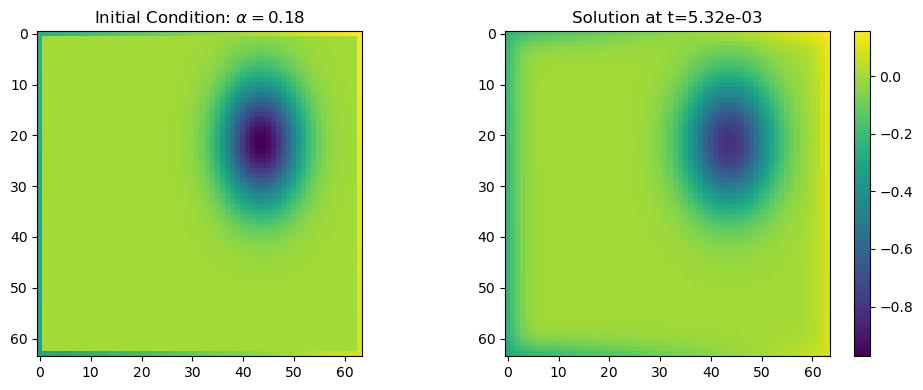

In [43]:
idx = 0     # which sample to visualize
t_idx = 30   # which time step to visualize

T = t_steps[t_idx].item()
alpha = data_labels[idx, 0].item()

A = data_A[idx, 0]  # (S, S)
U = data_U[idx, 0, :, :, t_idx]  # (S, S)

vmin, vmax = min(A.min(), U.min()), max(A.max(), U.max())
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im0 = axs[0].imshow(A, cmap="viridis", vmin=vmin, vmax=vmax)
axs[0].set_title(f"Initial Condition: $\\alpha={alpha:.2f}$")
im1 = axs[1].imshow(U, cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title(f"Solution at t={T:.2e}")
fig.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()

In [45]:
def random_boundary_mask(H, W, n, *, device=None, generator=None, include_corners=True):
    m = torch.zeros(H, W, dtype=torch.bool, device=device)
    m[[0, -1], :] = True
    m[:, [0, -1]] = True
    if not include_corners:
        m[0, 0] = m[0, -1] = m[-1, 0] = m[-1, -1] = False

    b = torch.where(m.flatten())[0]  # 1D indices of boundary pixels
    if n > b.numel():
        raise ValueError(f"n={n} > boundary points={b.numel()}")
    keep = b[torch.randperm(b.numel(), device=device, generator=generator)[:n]]

    m.zero_()
    m.view(-1)[keep] = True
    return m  # shape (H, W)

In [46]:
sample_shape = cfg.dataset.sampling.sample_shape
generator = torch.Generator().manual_seed(0)

boundary_obs = random_boundary_mask(sample_shape[1], sample_shape[2], 120)

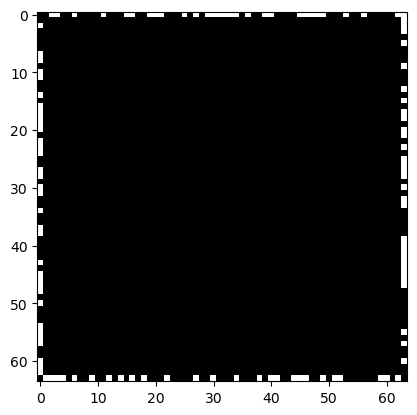

In [47]:
plt.imshow(boundary_obs.cpu(), cmap="gray")
plt.show()

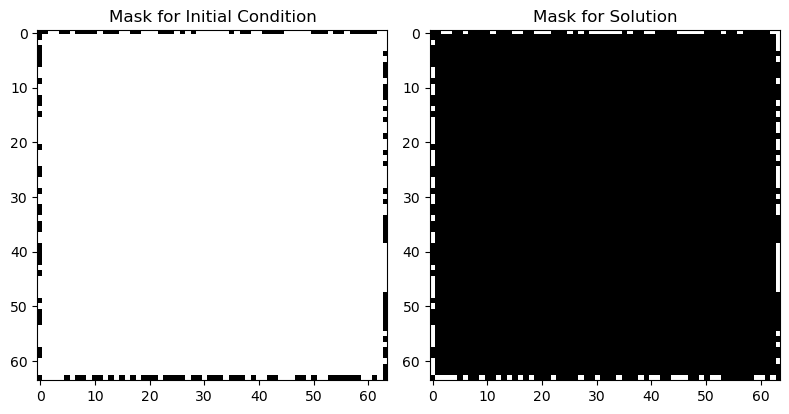

In [48]:
inside_mask = torch.ones_like(boundary_obs, dtype=torch.bool)
inside_mask[0, :] = 0
inside_mask[-1, :] = 0
inside_mask[:, 0] = 0
inside_mask[:, -1] = 0

mask_a = boundary_obs.clone().int()
mask_a[inside_mask] = 1
mask_u = boundary_obs.clone().int()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im0 = axs[0].imshow(mask_a.cpu(), cmap="gray", vmin=0, vmax=1)
axs[0].set_title("Mask for Initial Condition")
im1 = axs[1].imshow(mask_u.cpu(), cmap="gray", vmin=0, vmax=1)
axs[1].set_title("Mask for Solution")
plt.tight_layout()
plt.show()

In [49]:
obs_a = torch.tensor(A)
obs_u = torch.tensor(U)

dx = 1. / A.shape[-1]
ch_a = 1

sample_shape = (64, 2, 64, 64)

zeta_a = 50.0
zeta_u = 5.0
zeta_pde = 1.0
 
num_steps = 50

t_cond = torch.ones(sample_shape[0]) * T
alpha_cond = torch.ones_like(t_cond) * alpha
labels = torch.stack([t_cond, alpha_cond], dim=-1)

loss_fn_kwargs = {
    "obs_a": obs_a,
    "obs_u": obs_u,
    "mask_a": mask_a,
    "mask_u": mask_u,
    "dx": dx,
    "ch_a": ch_a,
    "alpha": alpha,
}

torch.set_float32_matmul_precision('high')

#for i in range(10):
samples, losses = dpde.sampling.edm_sampler(
    net=edm,
    device=device,
    sample_shape=sample_shape,
    loss_fn=dpde.sampling.heat_loss,
    loss_fn_kwargs=loss_fn_kwargs,
    labels=labels,
    zeta_a=zeta_a,
    zeta_u=zeta_u,
    zeta_pde=zeta_pde,
    num_steps=num_steps,
    debug=True,
    compile_net=False,
)

print(f"Final total loss: {losses[-1, 3]:.4f}")

Final total loss: 11.1430


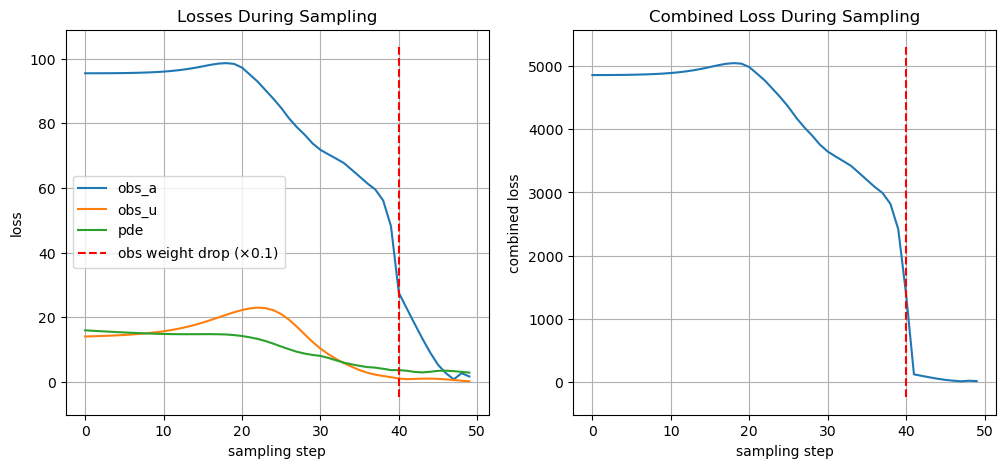

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :3])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, 3])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(['obs_a', 'obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
plt.show()

RMSE Initial Condition: 0.0068
RMSE Solution at t=0.005: 0.0892


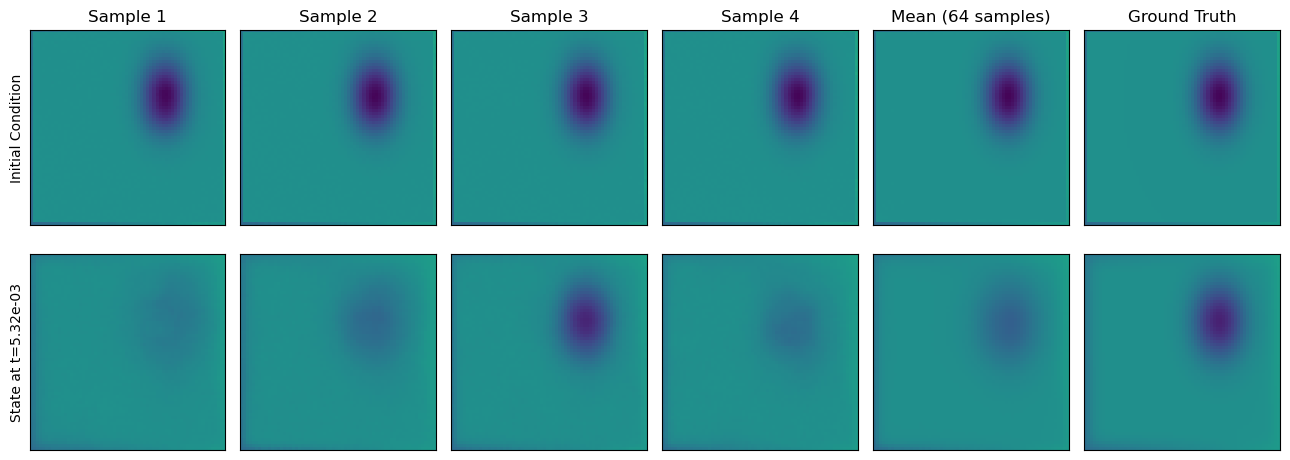

In [51]:
mean_val = samples.mean(axis=0)

print(f"RMSE Initial Condition: {np.sqrt(np.mean((samples[:, 0] - obs_a.numpy())**2)):.4f}")
print(f"RMSE Solution at t={T:.3f}: {np.sqrt(np.mean((samples[:, 1] - obs_u.numpy())**2)):.4f}")

fig, axs = plt.subplots(2, 6, figsize=(13, 5))
for i in range(4):
    axs[0, i].imshow(samples[i, 0], cmap='viridis', vmin=-1, vmax=1)
    axs[0, i].set(aspect="equal", xticks=[], yticks=[])
    axs[0, i].set_title(f'Sample {i+1}')
    if i == 0:
        axs[0, i].set_ylabel('Initial Condition')
    axs[1, i].imshow(samples[i, 1], cmap='viridis', vmin=-1, vmax=1)
    axs[1, i].set(aspect="equal", xticks=[], yticks=[])
    if i == 0:
        axs[1, i].set_ylabel(f'State at t={T:.2e}')

axs[0, 4].imshow(mean_val[0], cmap='viridis', vmin=-1, vmax=1)
axs[0, 4].set(aspect="equal", xticks=[], yticks=[], title=f"Mean ({sample_shape[0]} samples)")
axs[1, 4].imshow(mean_val[1], cmap='viridis', vmin=-1, vmax=1)
axs[1, 4].set(aspect="equal", xticks=[], yticks=[])

axs[0, 5].imshow(obs_a.numpy(), cmap='viridis', vmin=-1, vmax=1)
axs[0, 5].set(aspect="equal", xticks=[], yticks=[], title="Ground Truth")
axs[1, 5].imshow(obs_u.numpy(), cmap='viridis', vmin=-1, vmax=1)
axs[1, 5].set(aspect="equal", xticks=[], yticks=[])
plt.tight_layout()